# MNIST classifier based on fully connected NN (aka MLP) on PyTorch

### This notebook  was written by me during the [PyTorch for Deep Learning and Computer Vision course](https://www.udemy.com/pytorch-for-deep-learning-and-computer-vision/).

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [0]:

# Normally we should have this realization of transform, because of RGB image type, but MNIST is wb, so we need to count mean and std  for only one channel.
# transform = transforms.Compose([transforms.ToTensor(), 
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # first 3 0.5 - mean, second - std
#                                 ])

transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)), # first 3 0.5 - mean, second - std
                                ])

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [0]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0) # before it has w ch h, we need ch w h
#     print(image.shape)
    image = image * np.array((0.5, 0.5 ,0.5)) + np.array((0.5, 0.5, 0.5))
    image.clip(0, 1)
    return image

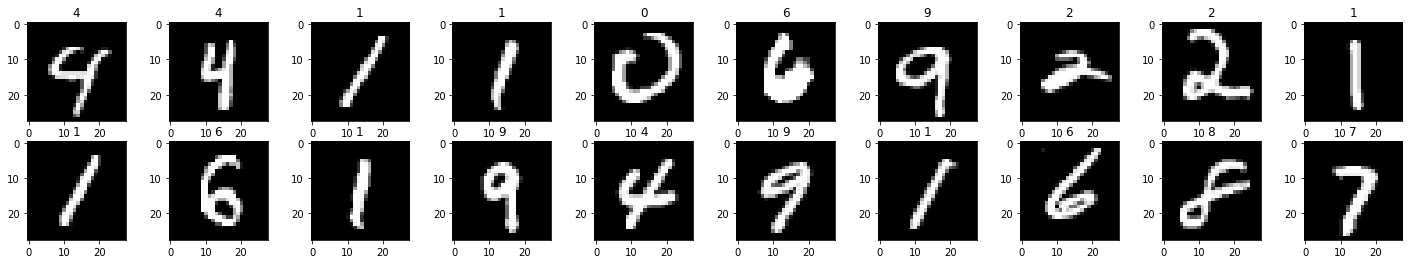

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [0]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # here we don`t use any activation function, because Cross entropy loss needs raw output from our NN
        return x      

In [0]:
model = Classifier(784, 115, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=115, bias=True)
  (linear2): Linear(in_features=115, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
epochs = 50

loss_history = []
accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_accuracy = 0.0
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    for inputs, labels in training_loader:
        
        # Algorithm:
        # 1. Make prediction
        # 2. Compute loss
        # 3. Zero old gradients
        # 4. Compute new gradients
        # 5. Make step by optimizer
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        
        running_accuracy += torch.sum(preds == labels.data)
        running_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)

                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                
                val_running_accuracy += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()

        running_accuracy += torch.sum(preds == labels.data)
        running_loss += loss.item()
        
        
        epoch_loss = running_loss/len(training_loader)
        epoch_accuracy = running_accuracy.float()/len(training_loader)
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)        
        
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_accuracy = val_running_accuracy.float()/len(validation_loader)
    
        val_loss_history.append(val_epoch_loss)
        val_accuracy_history.append(val_epoch_accuracy)
        print("Training loss: {:.4f}, Accuracy: {:.4f}. Val loss: {:.4f}, Val accuracy: {:.4f}".format(epoch_loss, epoch_accuracy, val_epoch_loss, val_epoch_accuracy))

Training loss: 0.4404, Accuracy: 87.3767. Val loss: 0.2502, Val accuracy: 92.7400
Training loss: 0.2144, Accuracy: 93.7850. Val loss: 0.1633, Val accuracy: 95.1400
Training loss: 0.1563, Accuracy: 95.4650. Val loss: 0.1480, Val accuracy: 95.4300
Training loss: 0.1256, Accuracy: 96.2700. Val loss: 0.1178, Val accuracy: 96.1000
Training loss: 0.1062, Accuracy: 96.9150. Val loss: 0.1032, Val accuracy: 96.8100
Training loss: 0.0910, Accuracy: 97.3783. Val loss: 0.1171, Val accuracy: 96.2600
Training loss: 0.0826, Accuracy: 97.5533. Val loss: 0.0978, Val accuracy: 96.8800
Training loss: 0.0721, Accuracy: 97.8850. Val loss: 0.1064, Val accuracy: 96.8300
Training loss: 0.0667, Accuracy: 97.9383. Val loss: 0.1025, Val accuracy: 96.7700
Training loss: 0.0580, Accuracy: 98.3283. Val loss: 0.0922, Val accuracy: 97.3300
Training loss: 0.0542, Accuracy: 98.4167. Val loss: 0.0913, Val accuracy: 97.2300
Training loss: 0.0500, Accuracy: 98.5317. Val loss: 0.0862, Val accuracy: 97.5000
Training loss: 0

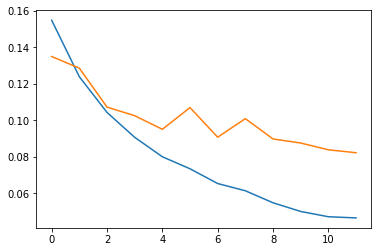

In [0]:
plt.plot(loss_history, label="training loss")
plt.plot(val_loss_history, label='validation loss')

In [0]:
plt.plot(accuracy_history, label='training accuracy')

<Response [200]>


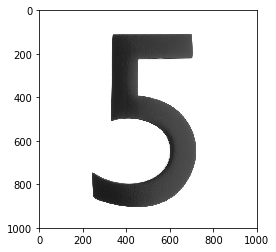

In [0]:
import requests
import PIL
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

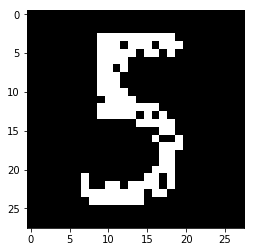

In [0]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [0]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())

5


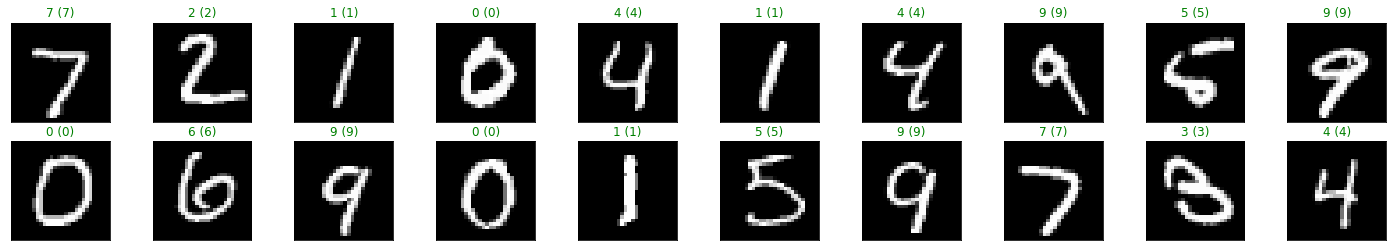

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx] == labels[idx] else 'red'))